<a href="https://colab.research.google.com/github/arm-on/1.5D-terrain-guarding/blob/master/prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import warnings

**Authentication**

In [ ]:
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/My Drive/THESIS/

Mounted at /gdrive
/gdrive/My Drive/THESIS


**Importing the necessary libraries**

In [ ]:
from experiment_v8 import *
from globals import *
from attention import *

**Configuration**

In [ ]:
np.set_printoptions(suppress=True)
experiment_phase = 'training' # phase: training/querying/continue
warnings.filterwarnings("ignore")
random_seed = 1234
tf.random.set_seed(random_seed)
seed(random_seed)
shared_files = read_csv_as_dict('shared_files.csv')
globals().update(shared_files)
project_path = 'June/EXP-2020-6-20/'
folder_path = 'wordexp/'
gloss_max_rank = 100000
num_head_words = 3000
input_emb_size = 300
lstm_output_size = 300
dense_output_size = 300
output_emb_size = 300
pretrained_input = True
fixed_embeddings = False
pretrained_target = True
normalize_vectors = False
add_context = False
augment_head = False
augment_gloss = False
save_train_test_samples = False
save_tools = False
save_weights = True
use_intent_classifier = False
max_hfake_per_sample = 5
gfake_per_sample = {
    3:5,
    4:5
}
context_max_rank = 100000
max_seq_len = 20
learning_rate = 1.0
margin = 1.0
num_epochs = 50
batch_size = 16
test_sample_size = 40
test_sample_topn = 10
input_vector_model = 'fasttext'
output_vector_model = 'fasttext'
data_sources = {'wikipedia','amid','dehkhoda-vy','moeen-vy','farsnet'}
vector_model_dir = {'fasttext':fasttext_dict_dir,'irblog':irblog2_wv_dir,'wiki200':wiki_wv_200_dir,'hamwv':hamshahri_wv_dir,'hamft':hamshahri_ft_dir,'wordak':wordak_wv_dir, 'wiki300':wiki_wv_300_dir,'twitter':twitter_wv_dir}
max_sense = {
    'wikipedia':500,
    'amid':500,
    'dehkhoda-vy':500,
    'moeen-vy':500,
    'farsnet':500
}
model_architecture = 'BiLSTM (attention)' #  bag of words, LSTM, BiLSTM, LSTM (attention), BiLSTM (attention), BiLSTM (multiheadattention)
num_heads = 8
d_model = 300
loss_function = 'cosine' # cosine, ranking
intent_project_path = 'July/2020-7-23/'
intent_folder_path = 'exp9/'
intent_maxlen = 20
intent_threshold = 0.3
intent_coefficient = 0.4
vec_sim_coefficient = 0.6

In [ ]:
if experiment_phase == 'training':
    log_dir = project_path+folder_path+'report.dat'
    log_obj = {
        'gloss':str(gloss_max_rank),
        'head':str(num_head_words),
        'input_emb':str(input_emb_size),
        'output_emb':str(output_emb_size),
        'dense_output':str(dense_output_size),
        'lstm_output':str(lstm_output_size),
        'pretrained_input':input_vector_model if pretrained_input else 'no',
        'pretrained_target':output_vector_model if pretrained_target else 'no',
        'fixed_embeddings':'yes' if fixed_embeddings else 'no',
        'normalize_vectors':'yes' if normalize_vectors else 'no',
        'intent_classifier':'yes' if use_intent_classifier else 'no',
        'context':str(context_max_rank) if add_context else 'no',
        'augment_head':str(max_hfake_per_sample) if augment_head else 'no',
        'augment_gloss':str(gfake_per_sample) if augment_gloss else 'no',
        'margin':str(margin),
        'seq_len':str(max_seq_len),
        'learning_rate':str(learning_rate),
        'batch_size':str(batch_size),
        'data_sources':" ".join(data_sources),
        'max_sense':str(max_sense),
        'model_architecture':model_architecture,
        'loss_function':loss_function,
        'intent_path':intent_project_path+intent_folder_path,
        'intent_maxlen':str(intent_maxlen),
        'intent_threshold':str(intent_threshold),
        'intent_coefficient':str(intent_coefficient),
        'vec_sim_coefficient':str(vec_sim_coefficient)
    }
    init_log(log_obj, log_dir)

**Loading**<br/>
* Data 
* Stopwords
* Normalizer
* Ranking of words by frequency
* Synonyms Set
* POS Tags
* Vector Model(s)

In [ ]:
word_tags = read_pickle(wordtags_dir) if use_intent_classifier else defaultdict(set)
ranking = read_pickle(ranking_dir)
all_words = set(ranking)
stopwords = read_lines(stopwords_dir)
normalizer = read_json(normalizer_dir)
synonyms = read_pickle(synonyms_dir)
if experiment_phase in {'training','continue'}:
    data = read_pickle(data_dir)
input_vec_model = read_pickle(vector_model_dir[input_vector_model])
output_vec_model = read_pickle(vector_model_dir[input_vector_model])
if use_intent_classifier == True:
    with open(intent_project_path+intent_folder_path+'model.json','r') as json_file:
        intent_model_arch = json_file.read()
    intent_model = tf.keras.models.model_from_json(intent_model_arch)
    intent_model.load_weights(intent_project_path+intent_folder_path+'weights.h5')
    intent_id2c = read_pickle(intent_project_path+intent_folder_path+'id2c.pkl')
    intent_g2id = read_pickle(intent_project_path+intent_folder_path+'intent-g2id.pkl')
    tools = {'normalizer':normalizer,'stopwords':stopwords,'synonyms':synonyms,'word_tags':word_tags, 'intent_g2id':intent_g2id, 'intent_maxlen':intent_maxlen, 'intent_model':intent_model, 'intent_threshold':intent_threshold, 'intent_id2c':intent_id2c, 'intent_coefficient':intent_coefficient, 'vec_sim_coefficient':vec_sim_coefficient}
else:
    tools = {'normalizer':normalizer,'stopwords':stopwords,'synonyms':synonyms,'word_tags':word_tags}

In [ ]:
items = []
sources_counter = Counter()
word_rank = {word:idx+1 for idx, word in enumerate(ranking)}
if experiment_phase in {'training','continue'}:
    for item in data:
        sources_counter[item['dic']] += 1
        new_item = {'word':item['word'],
                    'rank':word_rank[item['word']]+1 if item['word'] in all_words else len(ranking)+1,
                    'original_definition':item['meaning'],
                    'preprocessed_definition':item['meaning'],
                    'active':True,
                    'array':None,
                    'context':False,
                    'type':'main',
                    'sense_tags':item['tags'] if 'tags' in item else set(),
                    'general_tags':item['general_tags'] if 'general_tags' in item else set(),
                    'sid':item['sense_id'],
                    'source':item['dic'],
                    'phase':item['phase']
                    }
        items.append(new_item)

**Preparing the Train, Test and Dev Sets**

In [ ]:
if experiment_phase in {'training','continue'}:
    ## fixing the data sources and senses
    for item in items:
        if item['source'] not in data_sources or (item['sid']>max_sense[item['source']]):
            item['active'] = False
    items = [item for item in items if item['active'] == True]
    all_words = set([item['word'] for item in items])
    ## removing html tags
    for item in items:
        item['word'] = remove_html_tags(item['word'])
        item['original_definition'] = remove_html_tags(item['original_definition'])
        item['preprocessed_definition'] = remove_html_tags(item['preprocessed_definition'])
    ## deactivating samples without any Persian information
    for item in items:
        if not (has_any_persian(item['word']) and has_any_persian(item['original_definition'])):
            item['active'] = False
    items = [item for item in items if item['active'] == True]
    all_words = set([item['word'] for item in items])
    log_str = 'with Persian information - Number of Samples: '+str(len(items))+' - Number of Words: '+str(len(all_words))
    write_line_to_file(log_str, log_dir)
    ## normalizing characters
    for item in items:
        item['preprocessed_definition'] = normalize_characters(item['preprocessed_definition'], normalizer)
        item['word'] = normalize_characters(item['word'], normalizer)
    ## correcting whitespaces
    for item in items:
        item['word'] = correct_whitespaces(item['word'])
        item['preprocessed_definition'] = correct_whitespaces(item['preprocessed_definition'])
    ## tokenization
    for item in items:
        item['preprocessed_definition'] = tokenize(item['preprocessed_definition'])
    ## removing self-definition(s)
    for item in items:
        item['preprocessed_definition'] = remove_self_definition(item['preprocessed_definition'], item['word'])
    ## removing stopwords
    for item in items:
        item['preprocessed_definition'] = remove_stopwords(item['preprocessed_definition'], stopwords)
    for item in items:
        if item['word'] in stopwords:
            item['active'] = False
    items = [item for item in items if item['active'] == True]
    all_words = set([item['word'] for item in items])
    log_str = 'Stopwords removed - Number of Samples: '+str(len(items))+' - Number of Words: '+str(len(all_words))
    write_line_to_file(log_str, log_dir)
    ## deactivating unlearnables
    for item in items:
        if not has_vector(item['word'], output_vec_model):
            item['active'] = False
    items = [item for item in items if item['active'] == True]
    all_words = set([item['word'] for item in items])
    log_str = 'Unlearnables Removed - Number of Samples: '+str(len(items))+' - Number of Words: '+str(len(all_words))
    write_line_to_file(log_str, log_dir)
    ## deactivating short words
    for item in items:
        if len(item['word']) < 3:
            item['active'] = False
    items = [item for item in items if item['active'] == True]
    all_words = set([item['word'] for item in items])
    log_str = 'Short words removed - Number of Samples: '+str(len(items))+' - Number of Words: '+str(len(all_words))
    write_line_to_file(log_str, log_dir)
    ## deactivating short definitions
    for item in items:
        if len(item['preprocessed_definition']) == 1 and len(item['preprocessed_definition'][0]) < 3:
            item['active'] = False
    items = [item for item in items if item['active'] == True]
    all_words = set([item['word'] for item in items])
    log_str = 'Short definitions removed - Number of Samples: '+str(len(items))+' - Number of Words: '+str(len(all_words))
    write_line_to_file(log_str, log_dir)
    ## deactivating meaningless words
    for item in items:
        if len(item['preprocessed_definition']) == 0:
            item['active'] = False
    items = [item for item in items if item['active'] == True]
    all_words = set([item['word'] for item in items])
    log_str = 'Meaningless words removed - Number of Samples: '+str(len(items))+' - Number of Words: '+str(len(all_words))
    write_line_to_file(log_str, log_dir)
    ## normalizing heads by ranking (frequency)
    active_words = set([item['word'] for item in items if item['active']==True])
    temp_ranking = [word for word in ranking if word in active_words]
    frequent_words = set([word for word in temp_ranking][:num_head_words])
    context_words = set([word for word in temp_ranking][:context_max_rank])
    for item in items:
        if item['word'] not in frequent_words:
            if add_context == True:
                if item['word'] in context_words:
                    item['phase'] = 'train'
                    item['context'] = True
                else:
                    item['active'] = False
            else:
                item['active'] = False
    items = [item for item in items if item['active'] == True]
    all_words = set([item['word'] for item in items])
    main_words = set([item['word'] for item in items if item['context']==False])
    log_str = 'Normalized heads by frequency - Number of Samples: '+str(len(items))+' - Number of Words: '+str(len(all_words)) +' ('+str(len(main_words))+' Main Words)'
    write_line_to_file(log_str, log_dir)
    ## generating the comparison matrix
    h2id = {}
    id2h = {}
    for i, h in enumerate(frequent_words):
        h2id[h] = i
        id2h[i] = h
    comparison_matrix = zeros((num_head_words, output_emb_size))
    if pretrained_target == True:
        for item in items:
            if item['phase'] == 'train' and item['word'] in frequent_words:
                comparison_matrix[h2id[item['word']]] = output_vec_model[item['word']]
    ## normalizing the tokens based on their frequency
    tokens_lst = []
    for item in items:
        if item['phase'] == 'train':
            tokens_lst.extend(item['preprocessed_definition'])
    frequent_tokens = most_frequent(tokens_lst, gloss_max_rank)
    for item in items:
        item['preprocessed_definition'] = [token if token in frequent_tokens else 'UNK' for token in item['preprocessed_definition']]
        if 'UNK' in item['preprocessed_definition']:
            item['active'] = False
    items = [item for item in items if item['active'] == True]
    all_words = set([item['word'] for item in items])
    main_words = set([item['word'] for item in items if item['context']==False])
    log_str = 'Normalized tokens by frequency - Number of Samples: '+str(len(items))+' - Number of Words: '+str(len(all_words)) +' ('+str(len(main_words))+' Main Words)'
    write_line_to_file(log_str, log_dir)
    ## encoding the tokens
    t2id = {}
    id2t = {}
    t2id['PAD'] = 0
    t2id['UNK'] = 1
    id2t[0] = 'PAD'
    id2t[1] = 'UNK' 
    for i, t in enumerate(frequent_tokens, start=2):
        t2id[t] = i
        id2t[i] = t
    ## generating the embedding matrix
    embedding_matrix = zeros((len(frequent_tokens)+2, input_emb_size))
    if pretrained_input == True:
        for token in frequent_tokens:
            try:
                embedding_matrix[t2id[token]] = input_vec_model[token]
                if normalize_vectors == True and LA.norm(embedding_matrix[t2id[token]])>0.0:
                    embedding_matrix[t2id[token]] = embedding_matrix[t2id[token]]/LA.norm(embedding_matrix[t2id[token]])
            except:
                continue

    ## fixing the length of sequences
    for item in items:
        tokens = item['preprocessed_definition']
        item['preprocessed_definition'] = tokens[:max_seq_len] if len(tokens)>=max_seq_len else tokens+['PAD' for j in range(max_seq_len-len(tokens))]
    ## removing the words with definitions that are only consisted of 'PAD' and 'UNK'
    for item in items:
        tokens = item['preprocessed_definition']
        tokens = set(tokens)
        if tokens.issubset({'PAD','UNK'}):
            item['active'] = False
    items = [item for item in items if item['active'] == True]
    all_words = set([item['word'] for item in items])
    log_str = 'Infoless definitions (UNK and PAD) removed - Number of Samples: '+str(len(items))+' - Number of Words: '+str(len(all_words))
    write_line_to_file(log_str, log_dir)

    ## removing duplicates (samples with equal word and definition)
    # from the training data
    sample_count = Counter()
    for item in items:
        if item['phase'] == 'train':
            word = item['word']
            tokens = item['preprocessed_definition']
            sample_key = word+'-'+"-".join(tokens)
            sample_count[sample_key] += 1
            if sample_count[sample_key] > 1:
                item['active'] = False
    items = [item for item in items if item['active'] == True]
    all_words = set([item['word'] for item in items])
    main_words = set([item['word'] for item in items if item['context']==False])
    log_str = 'duplicates removed from training data - Number of Samples: '+str(len(items))+' - Number of Words: '+str(len(all_words))+' ('+str(len(main_words))+' Main Words)'
    write_line_to_file(log_str, log_dir)
    # from the testing and development data
    for item in items:
        if item['phase'] != 'train':
            word = item['word']
            tokens = item['preprocessed_definition']
            sample_key = word+'-'+"-".join(tokens)
            sample_count[sample_key] += 1
            if sample_count[sample_key] > 1:
                item['active'] = False
    items = [item for item in items if item['active'] == True]
    all_words = set([item['word'] for item in items])
    main_words = set([item['word'] for item in items if item['context']==False])
    log_str = 'duplicates removed from unseen data - Number of Samples: '+str(len(items))+' - Number of Words: '+str(len(all_words))+' ('+str(len(main_words))+' Main Words)'
    write_line_to_file(log_str, log_dir)
    ## generating the data
    for item in items:
        tokens = item['preprocessed_definition']
        nparray = [t2id[token] for token in tokens]
        nparray = array(nparray)
        item['array'] = nparray
    train = [item for item in items if item['phase'] == 'train']
    test = [item for item in items if item['phase'] == 'test']
    dev = [item for item in items if item['phase'] == 'dev']
    log_str = 'After Preprocessing: '+str(len(train))+' training samples, '+str(len(test))+' testing samples and '+str(len(dev))+' samples for development'
    write_line_to_file(log_str, log_dir)
    tools_part2 = {'t2id':t2id,'id2t':id2t,'h2id':h2id,'id2h':id2h,'embedding_matrix':embedding_matrix,'comparison_matrix':comparison_matrix}
    tools.update(tools_part2)
    train_sources_counter = Counter()
    for item in train:
        train_sources_counter[item['source']] += 1
    test_sources_counter = Counter()
    for item in test:
        test_sources_counter[item['source']] += 1
    dev_sources_counter = Counter()
    for item in dev:
        dev_sources_counter[item['source']] += 1
    write_line_to_file('Training Data: '+str(sum(train_sources_counter.values())), log_dir)
    write_line_to_file(str(train_sources_counter), log_dir)
    write_line_to_file('Development Data: '+str(sum(dev_sources_counter.values())), log_dir)
    write_line_to_file(str(dev_sources_counter), log_dir)
    write_line_to_file('Testing Data: '+str(sum(test_sources_counter.values())), log_dir)
    write_line_to_file(str(test_sources_counter), log_dir)

In [ ]:
if experiment_phase == 'training':
    words = list(set(list(h2id.keys())))
    with open(project_path+folder_path+'words'+str(num_head_words)+'.pkl','wb') as file:
        pickle.dump(words, file)

In [ ]:
if experiment_phase in {'training','continue'}:
    from copy import deepcopy
    # Making a counter to see if a sample already exists
    item_count = Counter()
    for item in items:
        word = item['word']
        tokens = item['preprocessed_definition']
        definition = " ".join(tokens)
        key = word+'-'+definition
        item_count[key] += 1

    # Augmenting (head words)

    head_augment = []
    all_heads = set([item['word'] for item in items if item['phase']=='train'])
    replaceable_heads = set([word for word in all_heads if word in synonyms])
    if augment_head == True:
        for item in train:
            if len(train) % 100000 == 0:
                print(len(train))
            word = item['word']
            tokens = item['preprocessed_definition']
            definition = " ".join(tokens)
            syn_words = synonyms[word]
            syn_words = set([w for w in syn_words if w in output_vec_model and w != word])
            if len(syn_words) == 0:
                continue
            if len(syn_words) >= max_hfake_per_sample:
                syn_candidates = sample(syn_words, max_hfake_per_sample)
            else:
                syn_candidates = list(syn_words)
            for candidate in syn_candidates:
                new_item = item.copy()
                new_item['word'] = candidate
                new_item['type'] = 'augment'
                key = candidate+'-'+definition
                if item_count[key] == 0:
                    head_augment.append(new_item)
                    item_count[key] += 1

    # Augmenting (gloss words)

    gloss_augment = []


    usable_synonyms = defaultdict()
    for (word, synset) in synonyms.items():
        temp_synset = set([syn for syn in synset if syn != word and syn in t2id])
        if len(temp_synset) > 0:
            usable_synonyms[word] = temp_synset

    gloss_augment = []

    if augment_gloss == True:
        for item in train:
            
            if item['type'] != 'main':
                continue
            word = item['word']
            tokens = item['preprocessed_definition']
            definition = " ".join(tokens)
            rep_tokens = set([token for token in tokens if token in usable_synonyms and token in input_vec_model])
            for num_tokens_to_replace in gfake_per_sample.keys():
                if len(rep_tokens) < num_tokens_to_replace:
                    continue
                remaining_samples = gfake_per_sample[num_tokens_to_replace]
                remaining_tries = 50
                while remaining_samples > 0 and remaining_tries > 0:
                    chosen_to_be_changed = set(sample(rep_tokens, num_tokens_to_replace))
                    what_to_replace_with = defaultdict()
                    for token in chosen_to_be_changed:
                        candidates = usable_synonyms[token]
                        what_to_replace_with[token] = sample(candidates, 1)[0]
                    new_item = deepcopy(item)
                    new_item['preprocessed_definition'] = [what_to_replace_with[t] if t in chosen_to_be_changed else t for t in new_item['preprocessed_definition']]
                    new_item['array'] = np.array([t2id[t] for t in new_item['preprocessed_definition']])
                    new_item_key = new_item['word'] + '-' + " ".join(new_item['preprocessed_definition'])
                    remaining_tries -= 1
                    if item_count[new_item_key] == 0:
                        gloss_augment.append(new_item)
                        item_count[new_item_key] += 1
                        remaining_samples -= 1


    train.extend(head_augment)
    del head_augment
    log_str = 'finished augmentation (head) - '+str(len(train))+' samples'
    write_line_to_file(log_str, log_dir)
    train.extend(gloss_augment)
    del gloss_augment
    log_str = 'finished augmentation (gloss) - '+str(len(train))+' samples'
    write_line_to_file(log_str, log_dir)
    del items

In [ ]:
if experiment_phase == 'training' and save_train_test_samples == True:
    train_data = defaultdict(list)
    test_data = defaultdict(list)
    train_original_data = defaultdict(list)
    test_original_data = defaultdict(list)
    for item in train:
        word = item['word']
        original_definition = " ".join(item['original_definition'].split()[:20])
        definition = " ".join([token for token in item['preprocessed_definition'] if not token == 'PAD'])
        train_data[word].append(definition)
        train_original_data[word].append(original_definition)
    for item in test:
        word = item['word']
        original_definition = " ".join(item['original_definition'].split()[:20])
        definition = " ".join([token for token in item['preprocessed_definition'] if not token == 'PAD'])
        test_data[word].append(definition)
        test_original_data[word].append(original_definition)

In [ ]:
if experiment_phase in {'training','continue'}:
    x_train = array([item['array'] for item in train])
    y_train = array([comparison_matrix[h2id[item['word']]] if item['word'] in h2id else output_vec_model[item['word']] for item in train])
    x_dev = array([item['array'] for item in dev])
    y_dev = array([comparison_matrix[h2id[item['word']]] if item['word'] in h2id else output_vec_model[item['word']] for item in dev])

**Saving the necessary variables**

In [ ]:
if experiment_phase == 'training':
    if save_tools == True:
        with open(project_path+folder_path+'tools.pkl','wb') as file:
            pickle.dump(tools, file)
    if save_train_test_samples == True:
        train_test_data = (train_data, train_original_data, test_data, test_original_data)
        with open(project_path+folder_path+'train_test_data.pkl','wb') as file:
            pickle.dump(train_test_data, file)

In [ ]:
if experiment_phase == 'training':
    emb_matrix_shape = embedding_matrix.shape
    additional_tools = {'comparison_matrix':comparison_matrix, 't2id':t2id, 'h2id':h2id, 'id2h':id2h}
    query_tools = (emb_matrix_shape, additional_tools)
    with open(project_path+folder_path+'query_tools.pkl','wb') as file:
        pickle.dump(query_tools, file)

**Loading Necessary Tools for Querying**

In [ ]:
if experiment_phase == 'querying':
    emb_matrix_shape , additional_tools = read_pickle(project_path+folder_path+'query_tools.pkl')
    tools.update(additional_tools)

**Making a Model and Training it**

*Bag of Words*

In [ ]:
if model_architecture == 'bag of words':
    sequence_input = Input(shape=(max_seq_len,), dtype='int32', name='input')
    embedding_layer = Embedding(emb_matrix_shape[0],
                                input_emb_size,
                                weights=[embedding_matrix] if 'embedding_matrix' in globals() else [np.zeros(emb_matrix_shape)],
                                input_length=max_seq_len,
                                trainable=not fixed_embeddings,
                                mask_zero=True, name='embedding')
    embedded_sequences = embedding_layer(sequence_input)
    mean_vector = Lambda(lambda x: mean(x, axis=1), name='lambda')(embedded_sequences)
    mean_vector = Flatten(name='flatten')(mean_vector)
    output = Dense(dense_output_size, activation='tanh', name='dense')(mean_vector)
    adadelta = optimizers.Adadelta(lr=learning_rate)
    model = Model(inputs=sequence_input, outputs=output)
    if loss_function == 'cosine':
        model.compile(loss=cosine_loss,
                    optimizer=adadelta,metrics=[cosine_sim])
    elif loss_function == 'ranking':
        model.compile(loss=rank_loss(margin),
                    optimizer=adadelta,metrics=[cosine_sim])

*LSTM (without attention)*

In [ ]:
if model_architecture == 'LSTM':
    sequence_input = Input(shape=(max_seq_len,), dtype='int32', name='input')
    embedding_layer = Embedding(emb_matrix_shape[0],
                                input_emb_size,
                                weights=[embedding_matrix]  if 'embedding_matrix' in globals() else [np.zeros(emb_matrix_shape)],
                                input_length=max_seq_len,
                                trainable=not fixed_embeddings,
                                mask_zero=True, name='embedding')
    embedded_sequences = embedding_layer(sequence_input)
    lstm = LSTM(lstm_output_size, return_sequences=False, name='lstm')(embedded_sequences)
    output = Dense(dense_output_size, activation='tanh', name='dense')(lstm)
    adadelta = optimizers.Adadelta(lr=learning_rate)
    model = Model(inputs=sequence_input, outputs=output)
    if loss_function == 'cosine':
        model.compile(loss=cosine_loss,
                    optimizer=adadelta,metrics=[cosine_sim])
    elif loss_function == 'ranking':
        model.compile(loss=rank_loss(margin),
                    optimizer=adadelta,metrics=[cosine_sim])

*BiLSTM (without attention)*

In [ ]:
if model_architecture == 'BiLSTM':
    sequence_input = Input(shape=(max_seq_len,), dtype='int32', name='input')
    embedding_layer = Embedding(emb_matrix_shape[0],
                                input_emb_size,
                                weights=[embedding_matrix] if 'embedding_matrix' in globals() else [np.zeros(emb_matrix_shape)],
                                input_length=max_seq_len,
                                trainable=not fixed_embeddings,
                                mask_zero=True, name='embedding')
    embedded_sequences = embedding_layer(sequence_input)
    lstm = Bidirectional(LSTM(lstm_output_size, return_sequences=False, name='lstm'))(embedded_sequences)
    output = Dense(dense_output_size, activation='tanh', name='dense')(lstm)
    adadelta = optimizers.Adadelta(lr=learning_rate)
    model = Model(inputs=sequence_input, outputs=output)
    if loss_function == 'cosine':
        model.compile(loss=cosine_loss,
                    optimizer=adadelta,metrics=[cosine_sim])
    elif loss_function == 'ranking':
        model.compile(loss=rank_loss(margin),
                    optimizer=adadelta,metrics=[cosine_sim])

*LSTM (with attention)*

In [ ]:
if model_architecture == 'LSTM (attention)':
    sequence_input = Input(shape=(max_seq_len,), dtype='int32', name='input')
    embedding_layer = Embedding(emb_matrix_shape[0],
                                input_emb_size,
                                weights=[embedding_matrix] if 'embedding_matrix' in globals() else [np.zeros(emb_matrix_shape)],
                                input_length=max_seq_len,
                                trainable=not fixed_embeddings,
                                mask_zero=True, name='embedding')
    embedded_sequences = embedding_layer(sequence_input)
    lstm, state_h, state_c = LSTM(lstm_output_size, return_sequences=True, return_state=True, name='lstm')(embedded_sequences)
    state_h = Lambda(lambda x: tf.expand_dims(x, 1), name='expand_dims')(state_h)
    state_h = Dense(300, name='d1')(state_h)
    lstm = Dense(300, name='d2')(lstm)
    weights, context_vector = AdditiveAttention(name='attention')([state_h, lstm])
    weights = Lambda(lambda x: tf.squeeze(x), name='squeezed_weights')(weights)
    output = Dense(dense_output_size, activation='tanh', name='dense')(context_vector)
    output = Lambda(lambda x: tf.squeeze(x), name='squeezed_output')(output)
    adadelta = optimizers.Adadelta(lr=learning_rate)
    model = Model(inputs=sequence_input, outputs=output)
    attention_model = Model(inputs=sequence_input, outputs=weights)
    if loss_function == 'cosine':
        model.compile(loss=cosine_loss,
                    optimizer=adadelta,metrics=[cosine_sim])
    elif loss_function == 'ranking':
        model.compile(loss=rank_loss(margin),
                    optimizer=adadelta,metrics=[cosine_sim])

*BiLSTM (with attention)*

In [ ]:
if model_architecture == 'BiLSTM (attention)':
    sequence_input = Input(shape=(max_seq_len,), dtype='int32', name='input')
    embedding_layer = Embedding(emb_matrix_shape[0],
                                input_emb_size,
                                weights=[embedding_matrix] if 'embedding_matrix' in globals() else [np.zeros(emb_matrix_shape)],
                                input_length=max_seq_len,
                                trainable=not fixed_embeddings,
                                mask_zero=True, name='embedding')
    embedded_sequences = embedding_layer(sequence_input)
    lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(lstm_output_size, return_sequences=True, return_state=True, name='lstm'))(embedded_sequences)
    state_h = tf.keras.layers.Concatenate()([forward_h, backward_h])
    state_c = tf.keras.layers.Concatenate()([forward_c, backward_c])
    state_h = tf.expand_dims(state_h, 1)
    state_h = Dense(300, name='d1')(state_h)
    lstm = Dense(300, name='d2')(lstm)
    weights, context_vector = AdditiveAttention()([state_h, lstm])
    weights = tf.squeeze(weights)
    output = Dense(dense_output_size, activation='tanh', name='dense')(context_vector)
    output = tf.squeeze(output)
    adadelta = optimizers.Adadelta(lr=learning_rate)
    model = Model(inputs=sequence_input, outputs=output)
    attention_model = Model(inputs=sequence_input, outputs=weights)
    if loss_function == 'cosine':
        model.compile(loss=cosine_loss,
                    optimizer=adadelta,metrics=[cosine_sim])
    elif loss_function == 'ranking':
        model.compile(loss=rank_loss(1.0),
                    optimizer=adadelta,metrics=[cosine_sim])

In [ ]:
# lstm: [2, 20, 600]
# state_h: [2, 600]
# new_lstm (after Dense(300)):  [2, 20, 300]
# new_state_h (after expand_dims): [2, 1, 600]
# new_state_h (after Dense(300)): [2, 1, 300]

*Multi-head Attention*

In [ ]:
if model_architecture == 'BiLSTM (multiheadattention)':
    sequence_input = Input(shape=(max_seq_len,), dtype='int32', name='input')
    embedding_layer = Embedding(emb_matrix_shape[0],
                                input_emb_size,
                                weights=[embedding_matrix] if 'embedding_matrix' in globals() else [np.zeros(emb_matrix_shape)],
                                input_length=max_seq_len,
                                trainable=not fixed_embeddings,
                                mask_zero=True, name='embedding')
    embedded_sequences = embedding_layer(sequence_input)
    lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(lstm_output_size, return_sequences=True, return_state=True, name='lstm'))(embedded_sequences)
    state_h = tf.keras.layers.Concatenate()([forward_h, backward_h])
    state_c = tf.keras.layers.Concatenate()([forward_c, backward_c])
    state_h = tf.expand_dims(state_h, 1)
    context_vector = MultiheadAttention(num_heads, d_model)([state_h, lstm, lstm])
    output = Dense(dense_output_size, activation='tanh', name='dense')(context_vector)
    output = tf.squeeze(output)
    adadelta = optimizers.Adadelta(lr=learning_rate)
    model = Model(inputs=sequence_input, outputs=output)
    if loss_function == 'cosine':
        model.compile(loss=cosine_loss,
                    optimizer=adadelta,metrics=[cosine_sim])
    elif loss_function == 'ranking':
        model.compile(loss=rank_loss(1.0),
                    optimizer=adadelta,metrics=[cosine_sim])

In [ ]:
if experiment_phase == 'training':
    with open(log_dir,'a+',encoding='utf-8') as file:
        model.summary(print_fn=lambda line: file.write(line + '\n'))
    write_line_to_file(str(model.loss), log_dir)

In [ ]:
if experiment_phase in {'training','continue'}:
    json_logging_callback = LambdaCallback(on_epoch_end=lambda epoch, logs:e_end('cosine_sim', epoch, logs, project_path+folder_path+'report.dat'))
    optimizer_weights_callback = LambdaCallback(on_epoch_end=save_optimizer_state(model, project_path+folder_path+'optimizer_weights.pkl'))
    model_weights_checkpoint = ModelCheckpoint(project_path+folder_path+'weights.h5', monitor='val_loss', verbose=0,save_best_only=True, mode='min', period=1, save_weights_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True,patience=2, mode='min',min_delta=0.001)

In [ ]:
if experiment_phase == 'continue':
    model.fit(x_train[:1000], y_train[:1000], epochs=1, batch_size=batch_size, validation_data=(x_dev, y_dev))
    with open(project_path+folder_path+'optimizer_weights.pkl') as f:
        optimizer_weights = pickle.load(f)
    model.optimizer.set_weights(optimizer_weights)   
    model.set_weights(project_path+folder_path+'weights.h5')
    start = time()
    history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(x_dev, y_dev)
    ,callbacks=[model_weights_checkpoint, early_stopping, json_logging_callback, optimizer_weights_callback]
    )   
    end = time()
    duration = round(end-start,2)
    write_line_to_file('Training Duration: '+str(duration)+' Seconds', log_dir)
elif experiment_phase == 'training':
    start = time()
    history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(x_dev, y_dev)
    ,callbacks=[model_weights_checkpoint, early_stopping, json_logging_callback, optimizer_weights_callback]
    )   
    end = time()
    duration = round(end-start,2)
    write_line_to_file('Training Duration: '+str(duration)+' Seconds', log_dir)
elif experiment_phase == 'querying':
    model.load_weights(project_path+folder_path+'weights.h5')

Epoch 1/50
6363/6363 [==============================] - 78s 12ms/step - loss: 0.5451 - cosine_sim: 0.4549 - val_loss: 0.6208 - val_cosine_sim: 0.3792
Epoch 2/50
6363/6363 [==============================] - 77s 12ms/step - loss: 0.5237 - cosine_sim: 0.4763 - val_loss: 0.6148 - val_cosine_sim: 0.3852
Epoch 3/50
6363/6363 [==============================] - 76s 12ms/step - loss: 0.5099 - cosine_sim: 0.4901 - val_loss: 0.6146 - val_cosine_sim: 0.3854
Epoch 4/50
6363/6363 [==============================] - 76s 12ms/step - loss: 0.4962 - cosine_sim: 0.5038 - val_loss: 0.6127 - val_cosine_sim: 0.3873
Epoch 5/50
6363/6363 [==============================] - 75s 12ms/step - loss: 0.4825 - cosine_sim: 0.5175 - val_loss: 0.6148 - val_cosine_sim: 0.3852
Epoch 6/50
6363/6363 [==============================] - 76s 12ms/step - loss: 0.4690 - cosine_sim: 0.5310 - val_loss: 0.6149 - val_cosine_sim: 0.3851


In [ ]:
# model.optimizer.set_weights(weight_values)

In [ ]:
if experiment_phase in {'training','continue'}:
    x_test = array([item['array'] for item in test])
    y_test = array([comparison_matrix[h2id[item['word']]] if item['word'] in h2id else output_vec_model[item['word']] for item in test])
    test_eval = model.evaluate(x_test, y_test)
    test_loss = test_eval[0]
    test_cosim = test_eval[1]
    log_str = 'Test Loss: '+str(test_loss)+' - '+'Cosine Similarity: ' + str(test_cosim)
    write_line_to_file(log_str, log_dir)

252/252 [==============================] - 1s 5ms/step - loss: 0.6142 - cosine_sim: 0.3858


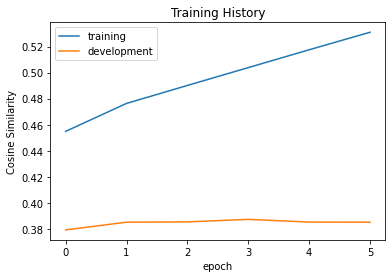

In [ ]:
if experiment_phase in {'training','continue'}:
    plt.plot(history.history['cosine_sim'])
    plt.plot(history.history['val_cosine_sim'])
    plt.title('Training History')
    plt.ylabel('Cosine Similarity')
    plt.xlabel('epoch')
    plt.legend(['training', 'development'], loc='upper left')
    plt.show()

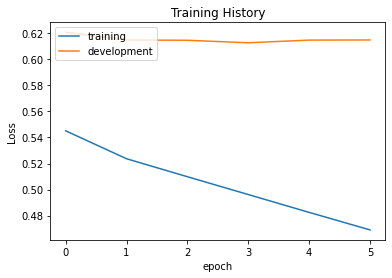

In [ ]:
if experiment_phase in {'training','continue'}:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Training History')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'development'], loc='upper left')
    plt.show()

**Evaluating the model based on its performance on the testing set**

In [ ]:
vec_sim_coefficient = 0.6
intent_coefficient = 0.4
intent_threshold = 0.5

In [ ]:
def query(inputs, topn, max_seq_len, models, tools):
    globals().update(models)
    words = inputs['words'] if 'words' in inputs else ['UNK' for definition in inputs['definitions']]
    definitions = inputs['definitions']
    general_tags= inputs['general_tags'] if 'general_tags' in inputs else [set() for definition in inputs['definitions']]
    sense_tags= inputs['sense_tags'] if 'sense_tags' in inputs else [set() for definition in inputs['definitions']]
    sources = inputs['sources'] if 'sources' in inputs else ['UNK' for definition in inputs['definitions']]
    preprocessed_definitions = []
    globals().update(tools)
    
    if 'intent_model' in globals():
        intent_tools = {'intent_g2id':intent_g2id, 'id2c':intent_id2c, 'normalizer':normalizer,'intent_maxlen':intent_maxlen
        ,'intent_model':intent_model, 'intent_threshold':intent_threshold}
        intent_classes = query_intent_classifier(definitions, intent_tools, method='names')
        intent_probs = query_intent_classifier(definitions, intent_tools, method='probs')
    else:
        intent_classes = [set() for i in range(len(definitions))]
    
    
    samples = []
    items = []
    for (word, definition) in zip(words, definitions):
        # making a sample out of the definition
        original_definition, preprocessed_definition, nparray = preprocess_definition(definition, max_seq_len, tools)
        preprocessed_definitions.append(preprocessed_definition)
        sample = nparray.reshape((-1, max_seq_len))
        samples.append(sample)
    samples = array(samples)
    samples = samples.reshape((-1, max_seq_len))
    # running the models on the sample
    preds = model.predict(samples)
    if 'attention_model' in models:
        weights = attention_model(samples) # batch_size*1*
    else:
        weights = array([array([1/max_seq_len for kprim in range(max_seq_len)]) for k in range(len(samples))])
    # calculating the cosine distance between the output and each head word
    dists = dist.cdist(preds, comparison_matrix, metric="cosine")
    sims = 1 - dists
    del dists
    sims = nan_to_num(sims)

    # combine intent score -begin
    if 'intent_model' in globals():
        intent_c2id = {}
        for (intent_i, intent_c) in intent_id2c.items():
            intent_c2id[intent_c] = intent_i
        for sample_idx, (s, p) in enumerate(zip(sims, intent_probs)):
            for head_idx in range(len(s)):
                head_word = id2h[head_idx]
                head_word_pos_tags = word_tags[head_word] # a set
                head_word_pos_ids = [intent_c2id[tag] for tag in head_word_pos_tags if tag in intent_c2id]
                curr_intent_score = 0
                for hwp_id in head_word_pos_ids:
                    if p[hwp_id] >= intent_threshold:
                        curr_intent_score += p[hwp_id] 
                sims[sample_idx][head_idx] = sims[sample_idx][head_idx] + min(intent_coefficient, intent_coefficient*curr_intent_score)
    # combine intent score -end

    candidate_ids = flip(sims.argsort(), 1)
    del sims
    
    
    
    for (cid, weight, word, definition, preprocessed_definition, nparray, source, stags, gtags, intent_class) in zip(candidate_ids, weights, words, definitions, preprocessed_definitions, samples, sources, sense_tags, general_tags, intent_classes):
        

        # curr_def_is_a_word = False
        # if definition.strip() in h2id:
        #     curr_def_is_a_word = True
        # if curr_def_is_a_word == True:
        #     curr_def_id = h2id[definition.strip()]
        #     cid = [curr_id for curr_id in cid if curr_def_id!=curr_id]
        
        # remove all definition words from cid -begin
        definition_tokens = set(definition.split())
        definition_tokens = set([dt for dt in definition_tokens if dt in h2id])
        definition_tokens_ids = set([h2id[dt] for dt in definition_tokens])
        cid = [curr_id for curr_id in cid if curr_id not in definition_tokens_ids]
        # remove all definition words from cid -end
        
        
        cid = list(cid)
        # getting the top words from the ranking
        topwords = [id2h[idx] for idx in cid[:topn]]
        # calculating the ranks
        num_words = len(h2id)
        accepted_output_words = synonyms[word] if word in synonyms else set()
        accepted_output_words.add(word)
        try:
            main_word_rank = cid.index(h2id[word])+1
        except:
            main_word_rank = num_words
        accepted_output_ids = [h2id[w] for w in accepted_output_words if w in h2id and w!=original_definition.strip()]
        try:
            output_word_id, given_word_rank = get_rank(cid, accepted_output_ids)
        except:
            given_word_rank = num_words
            output_word_id = False
        # making the report item
        item = {
            'main_word':word,
            'original_definition':definition,
            'preprocessed_definition':preprocessed_definition,
            'array':nparray,
            'attention':weight,
            'intent':set(intent_class),
            'main_word_rank':main_word_rank,
            'synset_word_rank':given_word_rank,
            'synset_word':'UNK' if not output_word_id else id2h[output_word_id],
            'topwords':topwords,
            'source':source,
            'sense_tags':stags,
            'general_tags':gtags
        }
        items.append(item)
    return items

In [ ]:
def stratified_sample(items, sources, num_head_words, sample_size):
    items = [item for item in items if item['source'] in sources]
    num_items = num_head_words
    section_size = int(num_items/sample_size)
    sections = [[] for i in range(sample_size)]
    for i in range(sample_size):
        sections[i] = [item for item in items if section_size*i<=item['rank']<=section_size*(i+1)]
    samples = [sample(sections[i], 1)[0] if len(sections[i])>0 else sample(sections[i-1]+sections[i+1],1)[0] for i in range(sample_size)]
    return samples

In [ ]:
if experiment_phase in {'training','continue'}:
    train_samples = stratified_sample(train, {'amid','moeen-vy','dehkhoda-vy'}, num_head_words, 500)
    train_inputs = {
        'definitions':[item['original_definition'] for item in train_samples],
        'words':[item['word'] for item in train_samples],
        'sources':[item['source'] for item in train_samples],
        'sense_tags':[item['sense_tags'] for item in train_samples],
        'general_tags':[item['general_tags'] for item in train_samples]
    }
    if 'attention_model' in globals():
        q = query(train_inputs, 10, max_seq_len, {'model':model, 'attention_model':attention_model}, tools)
    else:
        q = query(train_inputs, 10, max_seq_len, {'model':model}, tools)
    if use_intent_classifier == True:
        write_line_to_file('-------------', log_dir)
        intent_eval = evaluate_intent_classifier(q, word_tags)
        write_line_to_file('Intent Classifier Seen Evaluation: ', log_dir)
        write_line_to_file(str(intent_eval), log_dir)
    e = evaluate(q)
    write_line_to_file('-------------', log_dir)
    log_str = 'Seen Evaluation:\n'+'Median: '+str(e['main_eval']['median'])+', Variance: '+str(e['main_eval']['variance'])+', Acc@10: '+str(e['main_eval']['acc@10'])+', Acc@100: '+str(e['main_eval']['acc@100'])+'\n'
    write_line_to_file(log_str, log_dir)
    log_str = 'Seen Synonym Evaluation:\n'+'Median: '+str(e['synset_eval']['median'])+', Variance: '+str(e['synset_eval']['variance'])+', Acc@10: '+str(e['synset_eval']['acc@10'])+', Acc@100: '+str(e['synset_eval']['acc@100'])+'\n'
    write_line_to_file(log_str, log_dir)
    write_line_to_file(str(e['bad_results']), log_dir)

In [ ]:
if experiment_phase in {'training','continue'}:
    test_samples = stratified_sample(test, {'amid','moeen-vy','dehkhoda-vy'}, num_head_words, test_sample_size)
    test_inputs = {
        'definitions':[item['original_definition'] for item in test_samples],
        'words':[item['word'] for item in test_samples],
        'sources':[item['source'] for item in test_samples],
        'sense_tags':[item['sense_tags'] for item in test_samples],
        'general_tags':[item['general_tags'] for item in test_samples]
    }
    if 'attention_model' in globals():
        q = query(test_inputs, 10, max_seq_len, {'model':model, 'attention_model':attention_model}, tools)
    else:
        q = query(test_inputs, 10, max_seq_len, {'model':model}, tools)
    if use_intent_classifier == True:
        write_line_to_file('-------------', log_dir)
        intent_eval = evaluate_intent_classifier(q, word_tags)
        write_line_to_file('Intent Classifier Unseen Evaluation: ', log_dir)
        write_line_to_file(str(intent_eval), log_dir)
    e = evaluate(q)
    write_line_to_file('-------------', log_dir)
    log_str = 'Unseen Evaluation:\n'+'Median: '+str(e['main_eval']['median'])+', Variance: '+str(e['main_eval']['variance'])+', Acc@10: '+str(e['main_eval']['acc@10'])+', Acc@100: '+str(e['main_eval']['acc@100'])+'\n'
    write_line_to_file(log_str, log_dir)
    log_str = 'Unseen Synonym Evaluation:\n'+'Median: '+str(e['synset_eval']['median'])+', Variance: '+str(e['synset_eval']['variance'])+', Acc@10: '+str(e['synset_eval']['acc@10'])+', Acc@100: '+str(e['synset_eval']['acc@100'])+'\n'
    write_line_to_file(log_str, log_dir)
    write_line_to_file(str(e['bad_results']), log_dir)

In [ ]:
if experiment_phase in {'training','continue'}:
    synset_good10 = [item for item in q if 1<=item['synset_word_rank']<=10]
    synset_good100 = [item for item in q if 10<item['synset_word_rank']<=100]
    synset_bad100 = [item for item in q if 100<item['synset_word_rank']]
    save_group_reports(synset_good10, project_path+folder_path+'good10.html')
    save_group_reports(synset_good100, project_path+folder_path+'good100.html')
    save_group_reports(synset_bad100, project_path+folder_path+'bad100.html')

In [ ]:
if experiment_phase in {'training','continue'}:
    dictionaries = {'amid','moeen-vy','dehkhoda-vy'}
    for dictionary in dictionaries:
        test_samples = stratified_sample(test, {dictionary}, num_head_words, test_sample_size)
        test_inputs = {
            'definitions':[item['original_definition'] for item in test_samples],
            'words':[item['word'] for item in test_samples],
            'sources':[item['source'] for item in test_samples]
        }
        if 'attention_model' in globals():
            q = query(test_inputs, 10, max_seq_len, {'model':model, 'attention_model':attention_model}, tools)
        else:
            q = query(test_inputs, 10, max_seq_len, {'model':model}, tools)
        e = evaluate(q)
        write_line_to_file('-------------', log_dir)
        log_str = 'Source: '+dictionary
        write_line_to_file(log_str, log_dir)
        log_str = 'Unseen Evaluation:\n'+'Median: '+str(e['main_eval']['median'])+', Variance: '+str(e['main_eval']['variance'])+', Acc@10: '+str(e['main_eval']['acc@10'])+', Acc@100: '+str(e['main_eval']['acc@100'])+'\n'
        write_line_to_file(log_str, log_dir)
        log_str = 'Unseen Synonym Evaluation:\n'+'Median: '+str(e['synset_eval']['median'])+', Variance: '+str(e['synset_eval']['variance'])+', Acc@10: '+str(e['synset_eval']['acc@10'])+', Acc@100: '+str(e['synset_eval']['acc@100'])+'\n'
        write_line_to_file(log_str, log_dir)
        write_line_to_file(str(e['bad_results']), log_dir)
        correct_words = [item['main_word'] for item in q]
        input_descriptions = [item['original_definition'] for item in q]
        dict_evaluation_df = pd.DataFrame(list(zip(correct_words, input_descriptions)), columns=['word','description'])
        dict_evaluation_df.to_excel(project_path+folder_path+dictionary+'.xlsx', encoding='utf-8')
        for k in range(3):
            output_words = [item['topwords'][k] for item in q]
            evaluation_df = pd.DataFrame(list(zip(output_words, input_descriptions)), columns=['word','description'])
            evaluation_df.to_excel(project_path+folder_path+dictionary+'-'+str(k+1)+'.xlsx', encoding='utf-8')

In [ ]:
definition = 'از فوتبالیست فوتبال ایران'
inputs = {'definitions': [definition,
'آدمیان',
'زنده زنده']}
models = {'model':model}
if 'attention_model' in globals():
    models['attention_model'] = attention_model
query(inputs, 10, max_seq_len, models, tools)